# hmm grid search for bins and states


In [1]:
import sys
from pathlib import Path
from itertools import product

import numpy as np

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from hmm.preprocess import build_sequences_from_csv
from hmm.hmm_model import (
    train_supervised_hmm,
    train_unsupervised_hmm,
    sequence_accuracy,
    map_hidden_states_to_outcomes,
    convert_hidden_to_observed,
    infer_num_symbols,
)
from hmm.hmm_viterbi import viterbi_on_sequences


In [3]:
DATA_PATH = str(PROJECT_ROOT / "data" / "allseasons.csv")
HOLDOUT_SEASONS = (2018, 2024)

# state counts
STATE_GRID = [2] + list(range(8, 89, 8))


# bin counts
BIN_GRID = [3, 5, 7, 8, 9, 11]

UNSUPERVISED_KWARGS = {
    "smoothing": 1e-3,
    "max_iters": 75,
    "tol": 1e-3,
    "random_state": 0,
}


In [4]:
sequence_cache = {}

def load_sequences(num_bins):
    if num_bins not in sequence_cache:
        sequence_cache[num_bins] = build_sequences_from_csv(
            DATA_PATH,
            holdout_seasons=HOLDOUT_SEASONS,
            num_bins=num_bins,
            dean=False,
        )
    return sequence_cache[num_bins]



In [5]:
def train_and_evaluate(train_states, train_obs, test_states, test_obs, num_states):
    num_symbols = infer_num_symbols(train_obs)
    unique_labels = sorted(
        {int(label) for seq in train_states for label in np.unique(seq)}
    )
    use_unsupervised = num_states > len(unique_labels)

    if use_unsupervised:
        pi, A, B, _ = train_unsupervised_hmm(
            obs_sequences=train_obs,
            num_states=num_states,
            num_symbols=num_symbols,
            **UNSUPERVISED_KWARGS,
        )
    else:
        pi, A, B = train_supervised_hmm(
            state_sequences=train_states,
            obs_sequences=train_obs,
            num_states=num_states,
            num_symbols=num_symbols,
        )

    raw_pred_paths = viterbi_on_sequences(
        emissions=B,
        initials=pi,
        transitions=A,
        obs_sequences=test_obs,
    )

    if use_unsupervised:
        train_hidden_paths = viterbi_on_sequences(
            emissions=B,
            initials=pi,
            transitions=A,
            obs_sequences=train_obs,
        )
        state_mapping = map_hidden_states_to_outcomes(
            hidden_sequences=train_hidden_paths,
            true_sequences=train_states,
            num_hidden_states=num_states,
        )
        pred_paths = convert_hidden_to_observed(raw_pred_paths, state_mapping)
    else:
        pred_paths = raw_pred_paths

    test_accuracy = sequence_accuracy(test_states, pred_paths)
    return {
        "num_states": num_states,
        "test_accuracy": test_accuracy,
        "mode": "unsupervised" if use_unsupervised else "supervised",
    }



In [7]:
results = []

for num_bins in BIN_GRID:
    (
        train_states,
        train_obs,
        test_states,
        test_obs,
        train_seasons,
        test_seasons,
    ) = load_sequences(num_bins)

    for num_states in STATE_GRID:
        metrics = train_and_evaluate(
            train_states=train_states,
            train_obs=train_obs,
            test_states=test_states,
            test_obs=test_obs,
            num_states=num_states,
        )
        metrics["num_bins"] = num_bins
        results.append(metrics)
        print(
            f"bins={num_bins:2d}, states={num_states:2d}, "
            f"mode={metrics['mode']:<12s}, test_acc={metrics['test_accuracy']:.3f}"
        )



bins= 3, states= 2, mode=supervised  , test_acc=0.722
bins= 3, states= 8, mode=unsupervised, test_acc=0.634
bins= 3, states=16, mode=unsupervised, test_acc=0.510
bins= 3, states=24, mode=unsupervised, test_acc=0.564
bins= 3, states=32, mode=unsupervised, test_acc=0.629
bins= 3, states=40, mode=unsupervised, test_acc=0.595
bins= 3, states=48, mode=unsupervised, test_acc=0.604
bins= 3, states=56, mode=unsupervised, test_acc=0.500
bins= 3, states=64, mode=unsupervised, test_acc=0.650
bins= 3, states=72, mode=unsupervised, test_acc=0.509
bins= 3, states=80, mode=unsupervised, test_acc=0.675
bins= 3, states=88, mode=unsupervised, test_acc=0.709
bins= 5, states= 2, mode=supervised  , test_acc=0.733
bins= 5, states= 8, mode=unsupervised, test_acc=0.611
bins= 5, states=16, mode=unsupervised, test_acc=0.500
bins= 5, states=24, mode=unsupervised, test_acc=0.520
bins= 5, states=32, mode=unsupervised, test_acc=0.688
bins= 5, states=40, mode=unsupervised, test_acc=0.653
bins= 5, states=48, mode=uns

In [8]:
if not results:
    raise RuntimeError("grid search produced no results")

results_without_supervised = [r for r in results if r["mode"] != "supervised"]

sorted_results = sorted(results, key=lambda x: x["test_accuracy"], reverse=True)

print("top configurations:\n")
for entry in sorted_results[:10]:
    print(
        f"bins={entry['num_bins']:2d}, states={entry['num_states']:2d}, "
        f"mode={entry['mode']:<12s}, test_acc={entry['test_accuracy']:.3f}"
    )

best = sorted_results[0]
print("\nselected configuration (best test accuracy):")
print(best)



top configurations:

bins= 8, states= 2, mode=supervised  , test_acc=0.741
bins= 7, states= 2, mode=supervised  , test_acc=0.737
bins=11, states= 2, mode=supervised  , test_acc=0.736
bins= 9, states= 2, mode=supervised  , test_acc=0.735
bins= 5, states= 2, mode=supervised  , test_acc=0.733
bins= 3, states= 2, mode=supervised  , test_acc=0.722
bins= 3, states=88, mode=unsupervised, test_acc=0.709
bins= 5, states=32, mode=unsupervised, test_acc=0.688
bins= 9, states=32, mode=unsupervised, test_acc=0.688
bins= 3, states=80, mode=unsupervised, test_acc=0.675

selected configuration (best test accuracy):
{'num_states': 2, 'test_accuracy': np.float64(0.7411477411477412), 'mode': 'supervised', 'num_bins': 8}


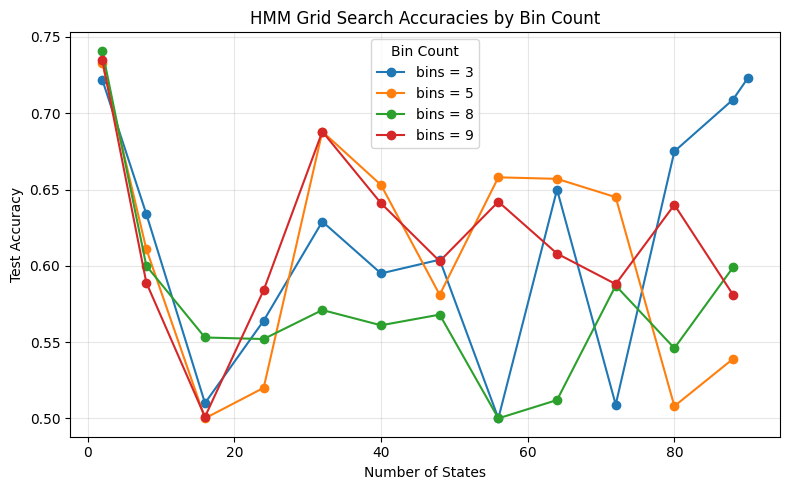

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# build dataframe from grid search results
results_df = pd.DataFrame(results)

# sort values to ensure lines are drawn in order of num_states
results_df = results_df.sort_values(["num_bins", "num_states"])

plt.figure(figsize=(8, 5))

for num_bins, group in results_df.groupby("num_bins"):
    if num_bins in [7, 11]:
        continue
    plt.plot(
        group["num_states"],
        group["test_accuracy"],
        marker="o",
        label=f"bins = {num_bins}",
    )

plt.xlabel("Number of States")
plt.ylabel("Test Accuracy")
plt.title("HMM Grid Search Accuracies by Bin Count")
plt.legend(title="Bin Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()